In [18]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

### Obtenção de Dados

In [9]:
df = pd.read_csv('../data/raw/data.csv')
df_dict = pd.read_csv("../data/external/dictionary.csv")

In [5]:
df_dict

,variavel,descricao,tipo,subtipo
0,species,"Espécie do pinguim (Adelie, Chinstrap, Gentoo).",qualitativa,nominal
1,island,"Ilha de origem do pinguim (Biscoe, Dream, Torg...",qualitativa,nominal
2,bill_length_mm,Comprimento do bico em milímetros.,quantitativa,contínua
3,bill_depth_mm,Profundidade do bico em milímetros.,quantitativa,contínua
4,flipper_length_mm,Comprimento da nadadeira em milímetros.,quantitativa,contínua
5,body_mass_g,Massa corporal em gramas.,quantitativa,contínua
6,sex,"Sexo do pinguim (Male, Female).",qualitativa,nominal


In [22]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.10,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.50,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.30,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,44.45,17.3,197.0,4050.0,MALE
4,Adelie,Torgersen,36.70,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,44.45,17.3,197.0,4050.0,MALE
340,Gentoo,Biscoe,46.80,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.40,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.20,14.8,212.0,5200.0,FEMALE


### Preparação de dados

In [13]:

print("\nDados faltantes por coluna:")
missing_data = df.isnull().sum()
display(missing_data[missing_data > 0])

# Remover colunas com uma alta porcentagem de valores ausentes (exemplo: > 40%)
threshold = 0.4  
columns_to_drop = missing_data[missing_data / len(df) > threshold].index
df = df.drop(columns=columns_to_drop)
print(f"\nColunas removidas por excesso de valores ausentes (> {threshold * 100}%):")
display(columns_to_drop)

# Imputar valores faltantes nas colunas restantes
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':  # Para variáveis categóricas
            df[col].fillna(df[col].mode()[0], inplace=True)  # Moda
        else:  # Para variáveis numéricas
            df[col].fillna(df[col].median(), inplace=True)  # Mediana

print("\nApós tratamento de valores faltantes:")
print(df.isnull().sum())


Dados faltantes por coluna:


bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


Colunas removidas por excesso de valores ausentes (> 40.0%):


Index([], dtype='object')


Após tratamento de valores faltantes:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [16]:
# --- 2. TRATAMENTO DE DADOS DISCREPANTES (OUTLIERS) ---

# Função para identificar outliers usando o IQR (Interquartile Range)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detectar e remover outliers em variáveis numéricas
outliers_dict = {}
for col in df.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        outliers_dict[col] = len(outliers)
        df = df[~df.index.isin(outliers.index)]

print("\nQuantidade de outliers removidos por coluna:")
display(outliers_dict)


Quantidade de outliers removidos por coluna:


{}

In [6]:
target_variable = 'species'  

# Separação das variáveis com base nos tipos e subtipos
useless_variables = (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)

continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)


In [10]:
X = df.drop(columns=[target_variable] + useless_variables)
y = df[target_variable]

In [12]:
# Nominal variables
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')), 
    ("encoding", OneHotEncoder(sparse_output=False))      
])

# Ordinal variables
ordinal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='median')),        # Trata valores ausentes
    ("encoding", OrdinalEncoder())                       # Codifica variáveis categóricas ordinais
])

# Continuous variables
continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),          # Trata valores ausentes
    ("scaling", StandardScaler())                        # Normaliza os dados
])

# Discrete variables
discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),                            # Imputa valores ausentes usando KNN
    ("scaling", StandardScaler())                        # Normaliza os dados
])

# Aplicação dos pipelines às colunas
preprocessor = ColumnTransformer(transformers=[
    ("nominal", nominal_preprocessor, nominal_variables), 
    ("ordinal", ordinal_preprocessor, ordinal_variables), 
    ("continuous", continuous_preprocessor, continuous_variables), 
    ("discrete", discrete_preprocessor, discrete_variables), 
])


In [19]:
# Print das variáveis separadas para conferência
print("Variáveis nominais:", nominal_variables)
print("Variáveis ordinais:", ordinal_variables)
print("Variáveis contínuas:", continuous_variables)
print("Variáveis discretas:", discrete_variables)

Variáveis nominais: ['island', 'sex']
Variáveis ordinais: []
Variáveis contínuas: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Variáveis discretas: []


### Seleção de modelos

--- Baseline ---
Accuracy: 0.4436
F1-Score: 0.2727

--- Random Forest ---
Accuracy: 0.9855
F1-Score: 0.9855

--- SVM ---
Accuracy: 0.9927
F1-Score: 0.9927

--- Logistic Regression ---
Accuracy: 0.9927
F1-Score: 0.9927

Melhor modelo baseado no F1-Score: SVM

Resumo dos Resultados:


,Model,Accuracy,F1-Score
0,Baseline,0.443636,0.272663
1,Random Forest,0.985455,0.985453
2,SVM,0.992727,0.992731
3,Logistic Regression,0.992727,0.992731


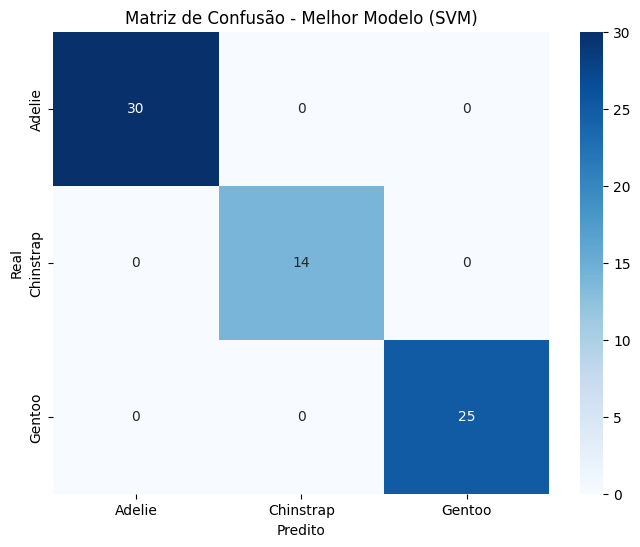


Relatório de Classificação:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [21]:
X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, stratify=y, random_state=42)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos a serem testados
models = {
    "Baseline": DummyClassifier(strategy="most_frequent"),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

results = {
    "Model": [],
    "Accuracy": [],
    "F1-Score": []
}

for name, model in models.items():
    y_pred = cross_val_predict(model, X_train, y_train, cv=kfold)
    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='weighted')

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["F1-Score"].append(f1)

    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

# Criar DataFrame de resultados
results_df = pd.DataFrame(results)

# Determinar o melhor modelo
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]['Model']
print(f"Melhor modelo baseado no F1-Score: {best_model_name}")

# Tabela de resultados
print("\nResumo dos Resultados:")
display(results_df)

# --- Avaliação Final com Matriz de Confusão ---
# Treinar o melhor modelo nos dados de treino
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f"Matriz de Confusão - Melhor Modelo ({best_model_name})")
plt.ylabel("Real")
plt.xlabel("Predito")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_test))